In [1]:
pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 11.4 MB/s eta 0:00:00


## Setup

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Prepare the data

In [4]:
import tensorflow as tf
import pathlib

# Define the paths to the training and testing data folders
train_data_path = "/content/drive/MyDrive/Azymer/AlzimerSVMModel/PreprocessSeg"
test_data_path = "/content/drive/MyDrive/Azymer/AlzimerSVMModel/PreprocessSeg"

# Use TensorFlow's image data generator to load the images and labels from the folders
train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data = train_data_generator.flow_from_directory(directory=train_data_path,
                                                      target_size=(128, 128),
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      shuffle=True)

test_data = test_data_generator.flow_from_directory(directory=test_data_path,
                                                    target_size=(128,128),
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    shuffle=False)

# Print the shapes of the data and labels
print("Training data shape:", train_data.image_shape)
print("Training labels shape:", train_data.classes.shape)
print("Testing data shape:", test_data.image_shape)
print("Testing labels shape:", test_data.classes.shape)

# Assign the data and labels to variables x_train, y_train, x_test, and y_test
x_train, y_train = train_data.next()
x_test, y_test = test_data.next()


Found 6400 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.
Training data shape: (128, 128, 3)
Training labels shape: (6400,)
Testing data shape: (128, 128, 3)
Testing labels shape: (6400,)


In [5]:
val_split = 0.1

val_indices = int(len(x_train) * val_split)
new_x_train, new_y_train = x_train[val_indices:], y_train[val_indices:]
x_val, y_val = x_train[:val_indices], y_train[:val_indices]

print(f"Training data samples: {len(new_x_train)}")
print(f"Validation data samples: {len(x_val)}")
print(f"Test data samples: {len(x_test)}")

Training data samples: 29
Validation data samples: 3
Test data samples: 32


In [6]:
import tensorflow as tf
import numpy as np

# Assume y_train and y_test have a shape of [?, 4]
# Convert them to integer labels
y_train_int = np.argmax(y_train, axis=1)
y_test_int = np.argmax(y_test, axis=1)

# Now you can convert them to one-hot encoded vectors with num_classes=4
y_train = tf.keras.utils.to_categorical(y_train_int, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test_int, num_classes=4)

y_train = y_train.squeeze()
y_test = y_test.squeeze()


## Configure the hyperparameters

In [7]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


## Use data augmentation

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


## Implement multilayer perceptron (MLP)

In [9]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [10]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Let's display patches for a sample image

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


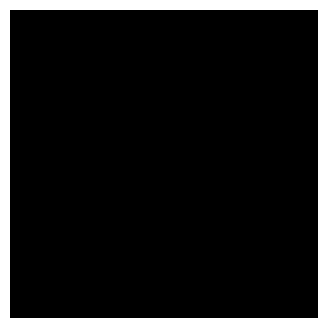

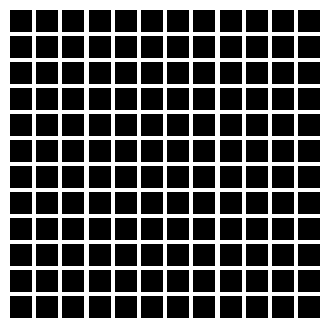

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [12]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

In [17]:
input_shape=(128,128,3)
num_classes=4
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the mode

In [18]:

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy", 
        metrics=["accuracy"],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        new_x_train,
        new_y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    y_pred = model.predict(x_test)
    accuracy = np.mean(np.argmax(y_test, axis=1) == np.argmax(y_pred, axis=1))
    top_5_accuracy = np.mean(
       [np.argmax(y_test[i]) in np.argsort(y_pred[i])[::-1][:5] for i in range(len(y_test))]
    )

# Print the test accuracies.
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

 


In [19]:

vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
1/1 [==============================] - 18s 18s/step - loss: 5.6646 - accuracy: 0.1923 - val_loss: 5.5140 - val_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 136ms/step - loss: 5.9534 - accuracy: 0.0000e+00 - val_loss: 10.8994 - val_accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 124ms/step - loss: 10.5750 - accuracy: 0.0000e+00 - val_loss: 10.8103 - val_accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 110ms/step - loss: 8.8522 - accuracy: 0.0000e+00 - val_loss: 5.8552 - val_accuracy: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 121ms/step - loss: 7.0520 - accuracy: 0.0000e+00 - val_loss: 5.6507 - val_accuracy: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 1s 1s/step - loss: 7.5303 - accuracy: 0.0000e+00 - val_loss: 10.7454 - val_accuracy: 0.3333
Epoch 7/100
1/1 [==============================] - 0s 133ms/step - loss: 7.5272 - accuracy: 0.2308 - val_loss: 5.6